In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

In [3]:
def inspect_h5_file(file_name):
    with h5py.File(file_name, "r") as file:
        def print_structure(name, obj):
            print(name)
        file.visititems(print_structure)

inspect_h5_file('/content/drive/My Drive/deep learning/Lab1/Train.h5')
inspect_h5_file('/content/drive/My Drive/deep learning/Lab1/Test.h5')


images
labels
images
labels


In [4]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/deep learning/Lab1/Train.h5', "r")
    train_set_x_orig = np.array(train_dataset["images"][:])
    train_set_y_orig = np.array(train_dataset["labels"][:])

    test_dataset = h5py.File('/content/drive/My Drive/deep learning/Lab1/Test.h5', "r")
    test_set_x_orig = np.array(test_dataset["images"][:])
    test_set_y_orig = np.array(test_dataset["labels"][:])

    classes = np.unique(train_set_y_orig)

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Load and preprocess data
train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_dataset()

y = [0], it's a '0' picture.


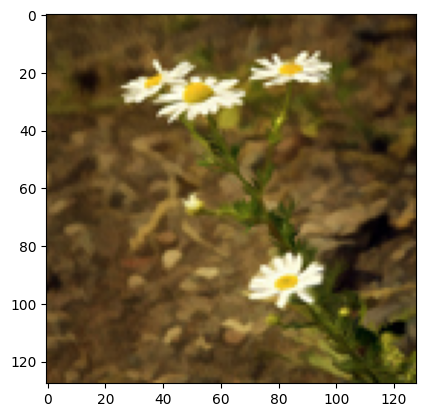

In [5]:
import matplotlib.pyplot as plt

index = 25
plt.imshow(train_x_orig[index])

# Assuming classes contain the names of the flower types, you can print the label like this:
print("y = " + str(train_y_orig[:, index]) + ", it's a '" + str(classes[np.squeeze(train_y_orig[:, index])]) + "' picture.")


In [6]:
m_train = train_x_orig.shape[0]
m_test  = test_x_orig.shape[0]
num_px  = train_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y_orig.shape))
print("test_x shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y_orig.shape))

Number of training examples: m_train = 2626
Number of testing examples: m_test = 120
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_x shape: (2626, 128, 128, 3)
train_y shape: (1, 2626)
test_x shape: (120, 128, 128, 3)
test_y shape: (1, 120)


In [7]:
print(train_x_orig[0].shape)

(128, 128, 3)


In [8]:
### START CODE HERE ### (≈ 2 lines of code)
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
### END CODE HERE ###

print("train_x_flatten shape: " + str(train_x_flatten.shape))
print("train_y shape: " + str(train_y_orig.shape))
print("test_x_flatten shape: " + str(test_x_flatten.shape))
print("test_y shape: " + str(test_y_orig.shape))
print("Sanity check after reshaping: " + str(train_x_flatten[0:5, 0]))


train_x_flatten shape: (49152, 2626)
train_y shape: (1, 2626)
test_x_flatten shape: (49152, 120)
test_y shape: (1, 120)
Sanity check after reshaping: [213 216 224 212 214]


In [9]:
train_set_x = train_x_flatten/255.
test_set_x = test_x_flatten/255.

In [10]:
# GRADED FUNCTION: softmax

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    s = exp_z / np.sum(exp_z, axis=0, keepdims=True)
    return s


In [11]:

z = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
print("Softmax output:\n", softmax(z))


Softmax output:
 [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [12]:
def initialize_with_zeros(dim, n_classes):
    W = np.zeros((dim, n_classes))
    b = np.zeros((n_classes, 1))
    return W, b

In [13]:
def forward_propagation(X, W, b):
    Z = np.dot(W.T, X) + b
    A = softmax(Z)
    return A


In [14]:
def compute_cost(A, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(A)) / m
    return cost


In [15]:
def backward_propagation(X, Y, A):
    m = X.shape[1]
    dZ = A - Y
    dw = np.dot(X, dZ.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    gradients = {"dw": dw, "db": db}
    return gradients


In [16]:
def update_parameters(W, b, gradients, learning_rate):
    W -= learning_rate * gradients['dw']
    b -= learning_rate * gradients['db']
    return W, b


In [17]:
def optimize(W, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        A = forward_propagation(X, W, b)
        cost = compute_cost(A, Y)
        gradients = backward_propagation(X, Y, A)
        W, b = update_parameters(W, b, gradients, learning_rate)

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")

    params = {"W": W, "b": b}
    grads = {"dw": gradients["dw"], "db": gradients["db"]}
    return params, grads, costs


In [18]:
def predict(W, b, X):
    A = forward_propagation(X, W, b)
    Y_prediction = np.argmax(A, axis=0)
    return Y_prediction

In [19]:
def model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.0001, print_cost=True):
    num_features = train_set_x.shape[0]
    num_classes = train_set_y.shape[0]

    W, b = initialize_with_zeros(num_features, num_classes)
    parameters, grads, costs = optimize(W, b, train_set_x, train_set_y, num_iterations, learning_rate, print_cost)

    W = parameters["W"]
    b = parameters["b"]

    Y_prediction_test = predict(W, b, test_set_x)
    Y_prediction_train = predict(W, b, train_set_x)

    # Calculate train/test accuracy
    train_accuracy = np.mean(Y_prediction_train == np.argmax(train_set_y, axis=0)) * 100
    test_accuracy = np.mean(Y_prediction_test == np.argmax(test_set_y, axis=0)) * 100

    print("train accuracy: {} %".format(train_accuracy))
    print("test accuracy: {} %".format(test_accuracy))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "W": W,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d


In [20]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [21]:
train_y_one_hot = convert_to_one_hot(train_y_orig, classes.size)
test_y_one_hot = convert_to_one_hot(test_y_orig, classes.size)


In [22]:
d = model(train_set_x, train_y_one_hot, test_set_x, test_y_one_hot, num_iterations=2000, learning_rate=0.0001, print_cost=True)

Cost after iteration 0: 1.6094379124340998
Cost after iteration 100: 1.4809790230418693
Cost after iteration 200: 1.4149051647574025
Cost after iteration 300: 1.372336489381762
Cost after iteration 400: 1.3416440214636625
Cost after iteration 500: 1.3179134628118345
Cost after iteration 600: 1.2986900128268086
Cost after iteration 700: 1.2825935558710222
Cost after iteration 800: 1.2687788229796593
Cost after iteration 900: 1.256693708408014
Cost after iteration 1000: 1.2459591212943677
Cost after iteration 1100: 1.2363042203395442
Cost after iteration 1200: 1.2275291817324143
Cost after iteration 1300: 1.219482639069279
Cost after iteration 1400: 1.2120473979524748
Cost after iteration 1500: 1.2051310440363387
Cost after iteration 1600: 1.1986595646613742
Cost after iteration 1700: 1.1925728930047992
Cost after iteration 1800: 1.1868217174492195
Cost after iteration 1900: 1.1813651469692914
train accuracy: 54.18888042650419 %
test accuracy: 53.333333333333336 %


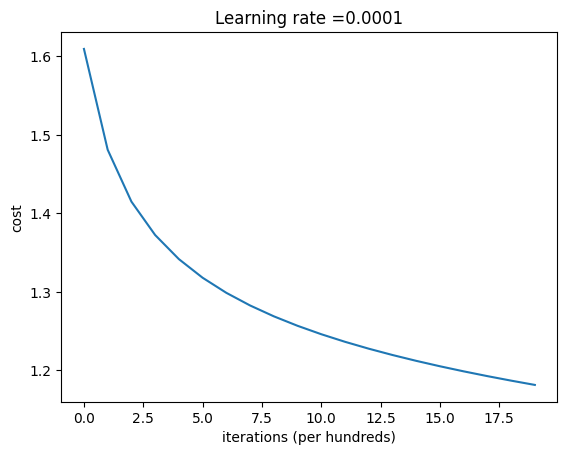

In [23]:
# Plot learning curves
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()


In [24]:
print("Type of test_set_y:", type(test_y_orig))
print("Shape of test_set_y:", test_y_orig.shape)
print("Type of Y_prediction_test:", type(d["Y_prediction_test"]))
print("Shape of Y_prediction_test:", d["Y_prediction_test"].shape)


Type of test_set_y: <class 'numpy.ndarray'>
Shape of test_set_y: (1, 120)
Type of Y_prediction_test: <class 'numpy.ndarray'>
Shape of Y_prediction_test: (120,)


In [33]:
# Retrieve W and b from the model output
W = d["W"]
b = d["b"]

# Now you can use W and b in your prediction code
random_index = random.randint(0, test_set_x.shape[1] - 1)
random_image = test_set_x[:, random_index].reshape(-1, 1)

# Make a prediction on the random image
predicted_probabilities = predict(W, b, random_image)  # Assuming predict returns probabilities
predicted_label = np.argmax(predicted_probabilities)  # Convert probabilities to class label

# Get the actual label
actual_label = np.argmax(test_y_orig[:, random_index])  # Extract actual label from one-hot encoded

# Display the predicted and actual labels
print(f"Predicted label: {predicted_label}")
print(f"Actual label: {actual_label}")


Predicted label: 0
Actual label: 0
